# Coefficients of Correlation Comparisson on Non-Monotonic Data (r vs τ vs ρ vs ξ)

## Dependencies & Imports

In [ ]:
# %pip install scipy
# %pip install tabulate

import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import kendalltau, spearmanr
import matplotlib.pyplot as plt

## ξ (Ksaai) Implementation

Based on this [Towards Data Science article](https://towardsdatascience.com/a-new-coefficient-of-correlation-64ae4f260310)

In [ ]:
def xicor(X, Y, ties=True):
    np.random.seed(42)
    n = len(X)
    order = np.array([i[0] for i in sorted(enumerate(X), key=lambda x: x[1])])
    if ties:
        l = np.array([np.sum(y >= Y[order]) for y in Y[order]])
        r = l.copy()
        for j in range(n):
            if np.sum(r[j] == r) > 1:
                tie_index = (r[j] == r)
                r[tie_index] = np.random.choice(
                    r[tie_index] - np.arange(np.sum(tie_index)), 
                    np.sum(tie_index), replace=False
                )
        return 1 - n * np.sum(np.abs(r[1:] - r[:-1])) / (2 * np.sum(l * (n - l)))
    else:
        r = np.array([np.sum(y >= Y[order]) for y in Y[order]])
        return 1 - 3 * np.sum(np.abs(r[1:] - r[:-1])) / (n**2 - 1)

## Generating Synthetic fMRI Signals

In [ ]:
n = 128
t = np.arange(n) * 2

stimulus = np.array([1 if (i % 64) < 32 else 0 for i in range(n)])

np.random.seed(123)
regions = ['Cortex1', 'Cortex2', 'Cortex3', 'Cortex4']

signal_strengths = np.array([0.85, 0.7, 0.45, 0.25])
hrf_delay = np.random.uniform(4, 8, 8)
signals = {}

for i, region in enumerate(regions):
    hrf = stats.gamma.pdf((t - hrf_delay[i]) / 4, a=6) * np.exp(-t/32)
    clean_signal = np.convolve(stimulus, hrf, mode='same')[:n]

    scaled_signal = clean_signal * signal_strengths[i]
    noise_level = 1 - signal_strengths[i]
    noise = np.random.normal(0, noise_level, n)
    signals[region] = scaled_signal + noise


## Compare All Coefficients

,Region,Pearson r,Spearman ρ,Kendall τ,ξ (Ksaai)
0,Cortex1,-0.027,-0.029,-0.024,0.387
1,Cortex2,0.073,0.049,0.040,0.319
2,Cortex3,-0.052,-0.062,-0.051,0.005
3,Cortex4,-0.007,0.029,0.024,0.073


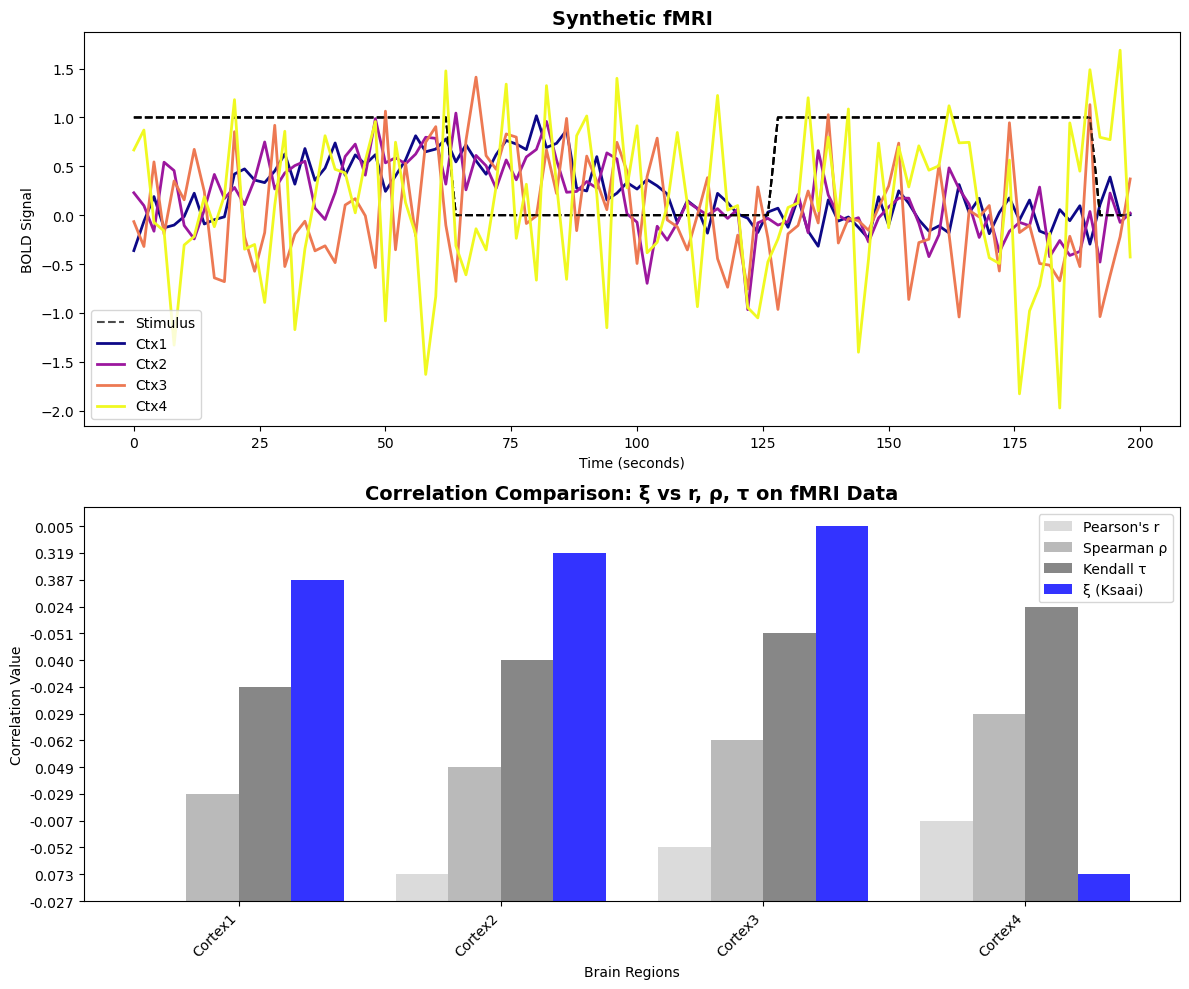

In [49]:
results = []
for region, signal in signals.items():
    r_pearson = np.corrcoef(stimulus, signal)[0,1]
    r_spearman, _ = spearmanr(stimulus, signal)
    r_kendall, _ = kendalltau(stimulus, signal)
    r_xicor = xicor(stimulus, signal)
    
    results.append({
        'Region': region,
        'Pearson r': f"{r_pearson:.3f}",
        'Spearman ρ': f"{r_spearman:.3f}", 
        'Kendall τ': f"{r_kendall:.3f}",
        'ξ (Ksaai)': f"{r_xicor:.3f}"
    })

df = pd.DataFrame(results)

display(df)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

colors = plt.cm.plasma(np.linspace(0, 1, 4))
for i, region in enumerate(regions):
    ax1.plot(t[:100], stimulus[:100], 'k--', alpha=0.7, label='Stimulus' if i==0 else "")
    ax1.plot(t[:100], signals[region][:100], color=colors[i], linewidth=2, 
             label=region.replace('Cortex', 'Ctx'))
ax1.set_title('Synthetic fMRI', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('BOLD Signal')
ax1.legend()

x = np.arange(len(regions))
width = 0.2

ax2.bar(x - 1.5*width, df['Pearson r'], width, label="Pearson's r", alpha=0.8, color='lightgray')
ax2.bar(x - 0.5*width, df['Spearman ρ'], width, label="Spearman ρ", alpha=0.8, color='darkgray')
ax2.bar(x + 0.5*width, df['Kendall τ'], width, label="Kendall τ", alpha=0.8, color='dimgrey')
ax2.bar(x + 1.5*width, df['ξ (Ksaai)'], width, label='ξ (Ksaai)', alpha=0.8, color='blue')

ax2.set_title('Correlation Comparison: ξ vs r, ρ, τ on fMRI Data', fontsize=14, fontweight='bold')
ax2.set_xlabel('Brain Regions')
ax2.set_ylabel('Correlation Value')
ax2.set_xticks(x)
ax2.set_xticklabels(regions, rotation=45, ha='right')
ax2.legend()

plt.tight_layout()
plt.savefig('fmri_correlation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()